In [ ]:
# Load Data
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install transformers torch
!pip install sentencepiece
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import pandas as pd
import numpy as np
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.6 MB/s eta 0:00:00


## 1. Define DataSet and Dataloaders for Claims Text

In [ ]:
class TextDataset(Dataset):
    def __init__(self, csv_file,label_map, tokenizer, max_length=4096): # adjust max length depending on tokenizer
        self.data_frame = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = label_map
        # redefine self.data_frame for integer valued labels
        self.data_frame['status'] = self.data_frame['status'].map(self.label_map)

    def __len__(self):
        return self.data_frame.shape[0]

    def __getitem__(self, idx):
        text = self.data_frame.iloc[idx]['claims']
        label = self.data_frame.iloc[idx]['status']

        # Encoding the text using the BERT tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
import torch

# Enabling gradient accumulation
accumulation_steps = 4  # How many steps to wait before performing a backward/update pass

# Optimizing memory management
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Set the max_split_size_mb to a value that works for your setup
torch.cuda.set_per_process_memory_fraction(0.9, device=0)


In [ ]:
input_path = '/content/drive/MyDrive/CSCI567 Project/data/text_df.csv'

# Load the dataset
label_map = {'ABN': 0, 'ISS': 1}
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
dataset = TextDataset(input_path,label_map=label_map, tokenizer= tokenizer,max_length = 1024)

# Example dataset size
total_size = len(dataset)

# Define the proportions
train_size = int(0.95* total_size)
val_size = int(0.025* total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# define dataloaders
BATCH_SIZE = 2
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

9440
248
249


## 2. Fine Tune Pretrained BigBird

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

# Number of epochs
num_epochs = 20

# load model for BERT classification
model = GPT2ForSequenceClassification.from_pretrained(model_name,num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Scheduler
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# set model to training mode and Fine Tune
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Reset gradients at the start of the epoch
    for batch_idx, batch in enumerate(train_dataloader):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss / accumulation_steps  # Normalize the loss

        # Backward pass
        loss.backward()  # Accumulate gradients

        # Optimizer and scheduler steps are performed after the specified number of accumulation steps
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_dataloader):
            optimizer.step()    # Update model parameters
            scheduler.step()    # Update learning rate
            optimizer.zero_grad()  # Reset gradients

        # Print loss or any other metrics you want to track
        # Optionally, you can print the average loss over accumulation steps
        if (batch_idx + 1) % accumulation_steps == 0:
            print(f"Loss: {loss.item() * accumulation_steps}")  # Multiply back to get the actual loss value


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Streaming output truncated to the last 5000 lines.
Loss: 0.022547978907823563
Loss: 0.001273151719942689
Loss: 0.002447862643748522
Loss: 0.007721323985606432
Loss: 0.000997442053630948
Loss: 0.4678315222263336
Loss: 0.00011854650801979005
Loss: 0.0001610856270417571
Loss: 0.7396534085273743
Loss: 0.0033934342209249735
Loss: 0.011926169507205486
Loss: 0.000885864021256566
Loss: 0.021872658282518387
Loss: 0.02234918437898159
Loss: 0.0019297864055261016
Loss: 0.0009540225146338344
Loss: 0.001178874634206295
Loss: 0.00046962147462181747
Loss: 0.1106342300772667
Loss: 0.0010169869055971503
Loss: 6.866171315778047e-05
Loss: 0.0010262323776260018
Loss: 0.01974331960082054
Loss: 0.023584555834531784
Loss: 0.0007636817754246294
Loss: 3.814684532699175e-06
Loss: 4.470160638447851e-05
Loss: 0.003438071347773075
Loss: 0.03183487802743912
Loss: 0.0002841500099748373
Loss: 9.244229295291007e-05
Loss: 0.002984898164868355
Loss: 0.006015507970005274
Loss: 0.008021690882742405
Loss: 0.0002949032059404

## 3. Evaluate BigBird Performance on validation set

In [ ]:
# set model to evaluation mode
model.eval()

# store predictions in list
val_predictions = []
val_labels = []

# Evaluate on validation set
with torch.no_grad():
    for batch in val_dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Get predictions
        predictions = torch.argmax(logits, dim=1)
        labels = batch['labels']

        # Store predictions
        val_predictions.extend(predictions.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

In [ ]:
# Use SKLearn library to predict F1, Precision, Recall
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score

f1 = f1_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)
accuracy = accuracy_score(val_labels, val_predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.6290322580645161
F1 Score: 0.7245508982035928
Precision: 0.7159763313609467
Recall: 0.7333333333333333


169
79


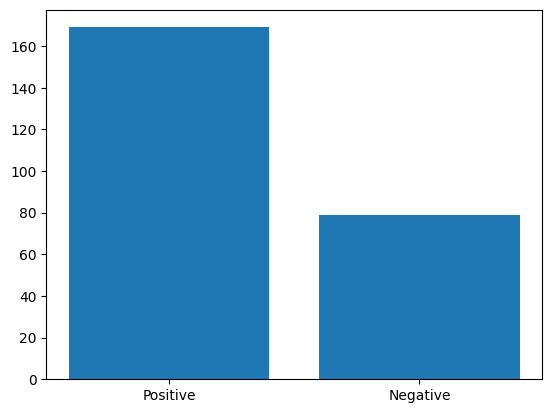

In [ ]:
# Plot the proportion of positive vs. negative predictions
import matplotlib.pyplot as plt

print(val_predictions.count(1))
print(val_predictions.count(0))

plt.bar(['Positive', 'Negative'], [val_predictions.count(1), val_predictions.count(0)])
plt.show()

In [ ]:
model_save_path = '/content/drive/MyDrive/CSCI567/project/bigbird_state_dict.pth'
torch.save(model.state_dict(), model_save_path)

RuntimeError: ignored